In [1]:
# some standard python imports #
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import MAS_library as MASL
import smoothing_library as SL



In [22]:
def densemap(df,grid,BoxSize, MAS, R, Filter, threads):
    pos = df.loc[:,['x','y','z']].to_numpy(dtype=np.float32)

    #Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
    delta_g = np.zeros((grid,grid,grid), dtype=np.float32)
    MASL.MA(pos, delta_g, BoxSize, MAS, verbose=False)
    delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0
    
    
    
    # smooth the field
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    delta_g_smoothed = SL.field_smoothing(delta_g, W_k, threads)
    
    
    return delta_g_smoothed

In [56]:
def sorter(df, start, cur, col):
    para=df[col]
    para_mean=para.mean()
    para_std=para.std()

    low=para_mean+((cur-1)*para_std)
    high=para_mean+(cur*para_std)
    
    if cur == start:
        rows=df[df[col] < high].index
        newdf= df.loc[rows]
    if cur-1 == -1*cur:
        rows=df[df[col] >= low].index
        newdf= df.loc[rows]
    else:
        condition = (df[col] >= low) & (df[col] < high)
        rows=df[condition].index
        newdf= df.loc[rows]

    return newdf

In [57]:
#Read in galaxy data
filename = 'galaxycat.csv'
galaxycat  = pd.read_csv(filename)
ogcat = pd.read_csv(filename)

In [58]:
##Read in the snapshot data 

snapshot = 'snapshot_500'          #name of Gadget file
ptypes = [1]                       #this specifies that the simulation only contains dark matter particles
grid = 100                         #this is how you specify the size of your density grid (I just made it 100x100)
MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
do_RSD   = False                   #don't do redshift-space distortions (https://en.wikipedia.org/wiki/Redshift-space_distortions)
axis     = 0                       #axis along which to place RSD; not used here
verbose  = False                   #whether to print information on the progress


# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

BoxSize = 115  #from simulation params. Mpc/h 
R = 4       #smoothing kernal in Mpc/h
grid = delta.shape[0]
Filter  = 'Top-Hat' #type of smoothing kernal 
threads = 8   #computer threads, for parallelization 

# compute FFT (fast fourier transform) of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
delta_smoothed = SL.field_smoothing(delta, W_k, threads)


# building luminosity bins
k_mag=galaxycat['K_Mag']

k_mean=k_mag.mean()
k_std=k_mag.std()

lum_list=[]
col='K_Mag'
start_sig=-2
size=np.abs(start_sig*2)+2

for i in range(size):
    cur_sig=start_sig+i
    tempdf=sorter(galaxycat, start_sig, cur_sig, col)
    lum_list.append(tempdf)




# k_min=k_mag.min()
# k_max=k_mag.max()

# start_sig=-3
# size=np.abs(start_sig*2)+1

# lum_list=[]
# for i in range(size):
#     sig=start_sig+i
#     upper=k_mean+sig
    
#     sig_rows = galaxycat[galaxycat['K_Mag'] < upper].index
#     newcat = galaxycat.loc[sig_rows]
#     galaxycat=galaxycat.drop(sig_rows)

#     lum_list.append(newcat)

# smoothed for each bin
smoothed_list=[]
for i in lum_list:
    temp_smooth=densemap(i,grid,BoxSize, MAS, R, Filter, threads)
    smoothed_list.append(temp_smooth)



/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_11533/1762858434.py:7: RuntimeWarning: invalid value encountered in divide
  delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0


/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6834: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6835: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


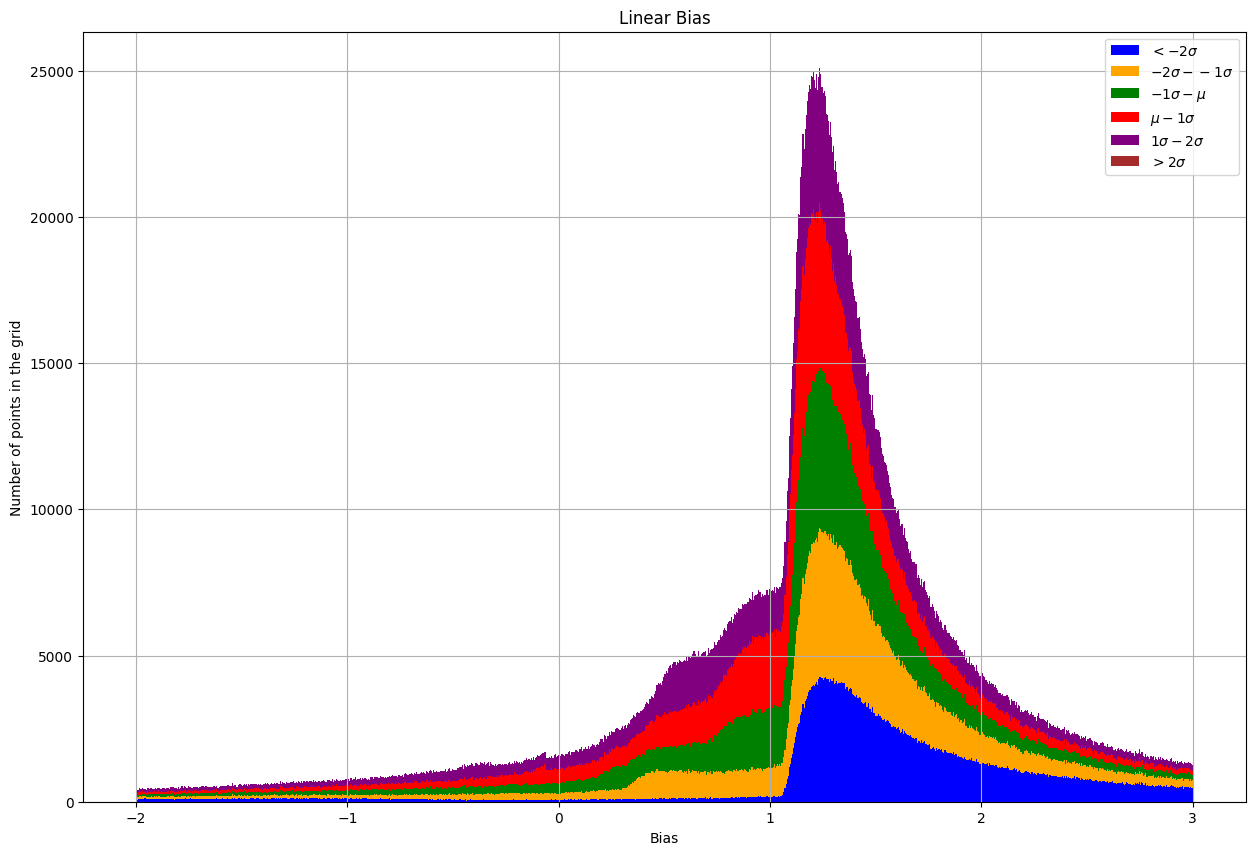

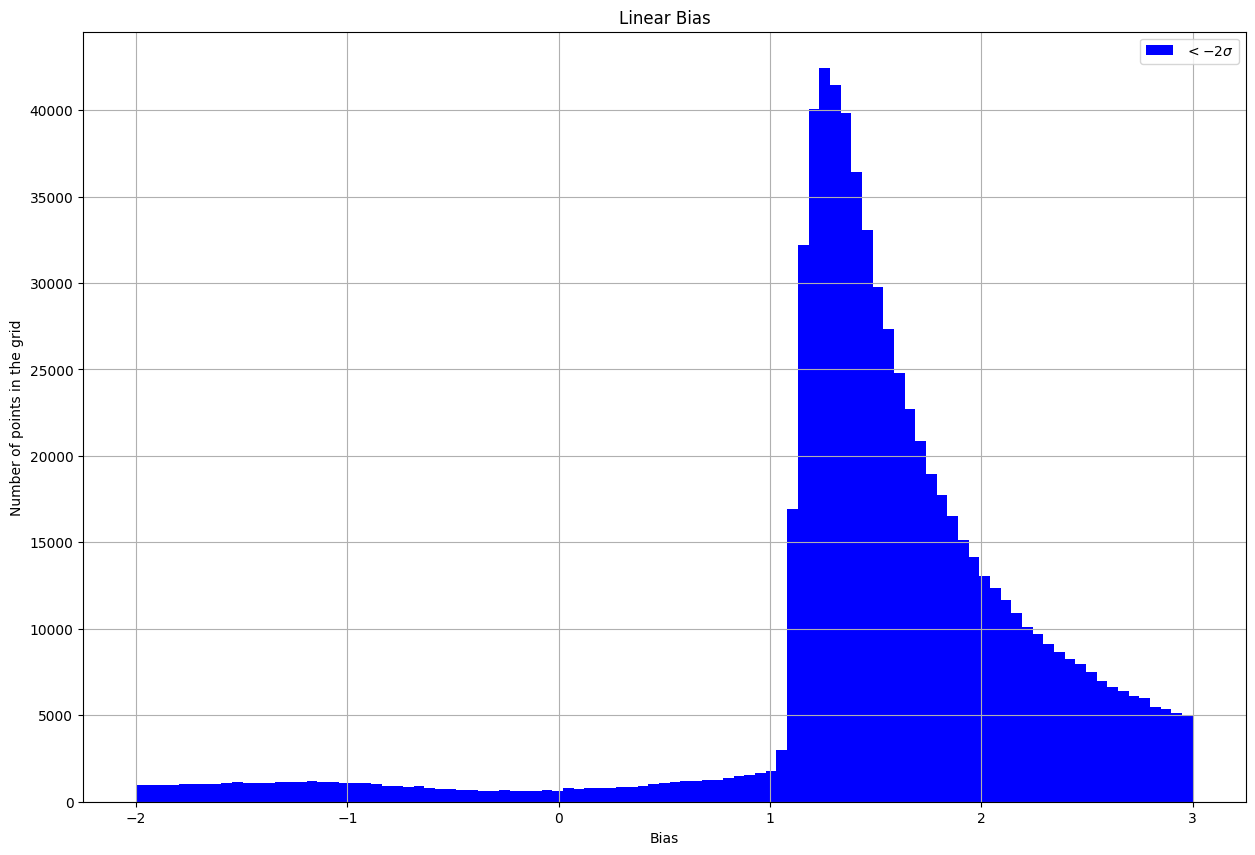

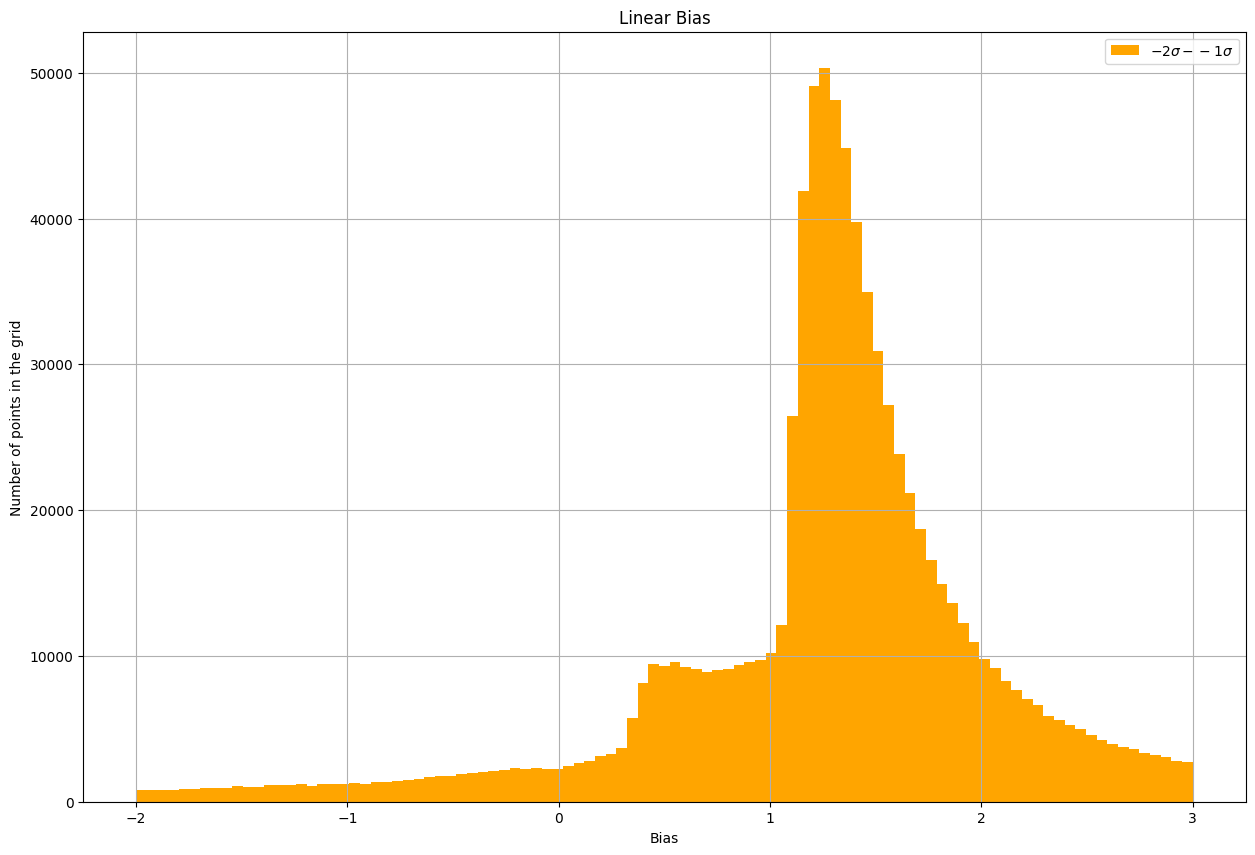

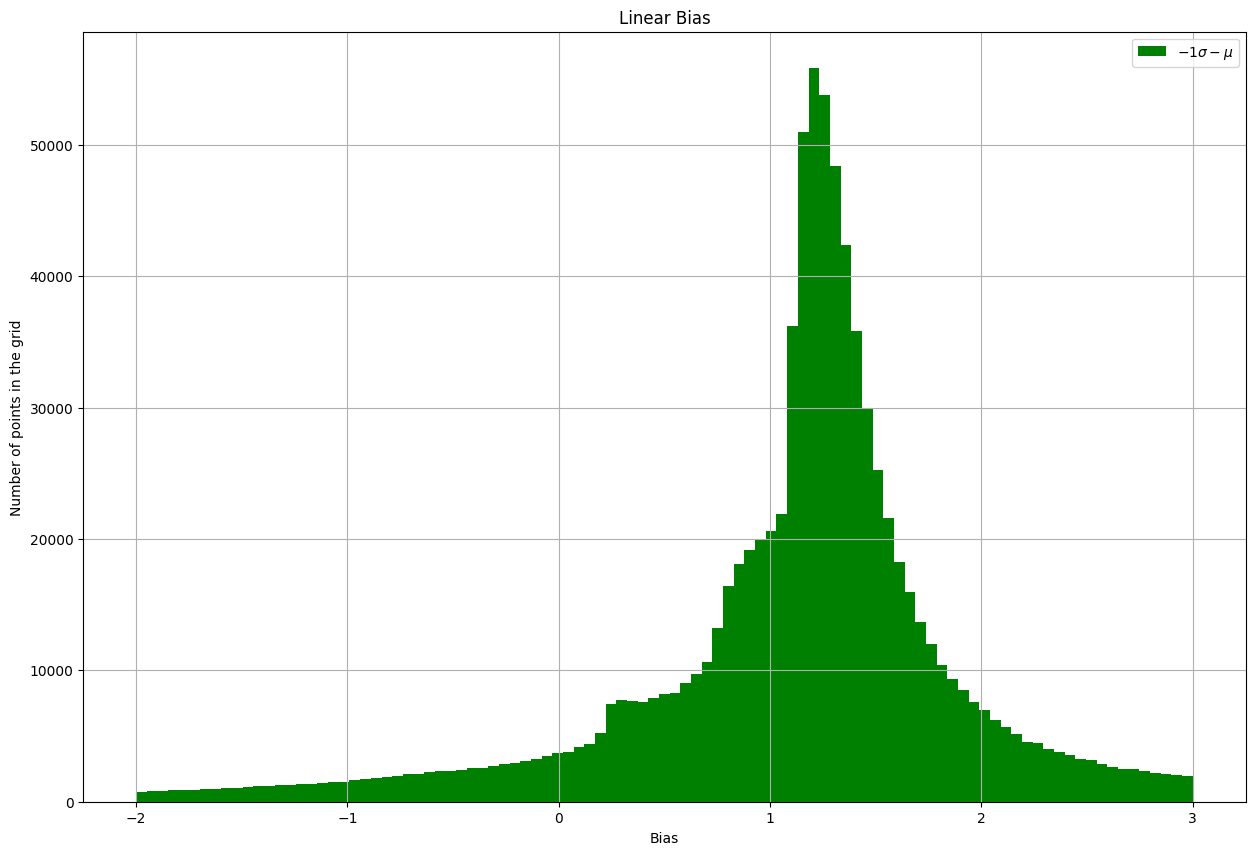

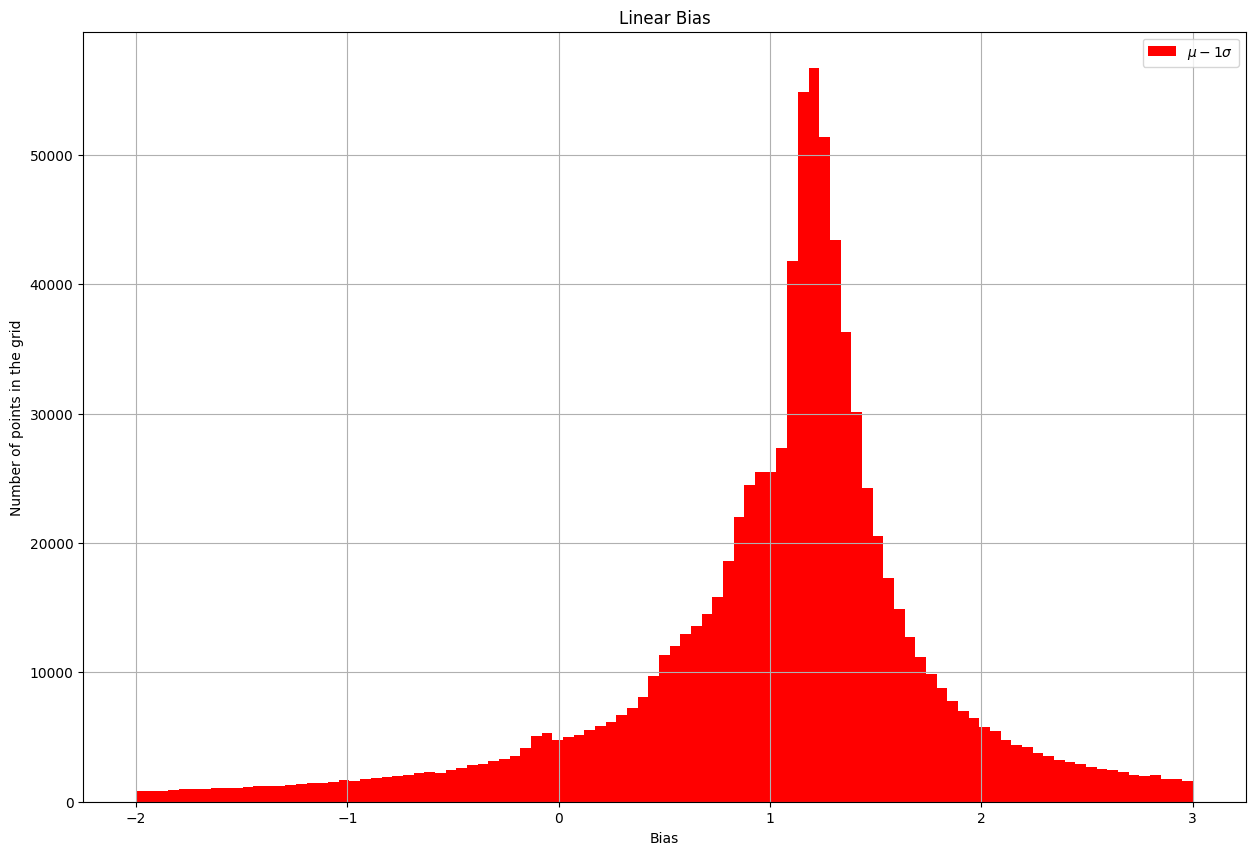

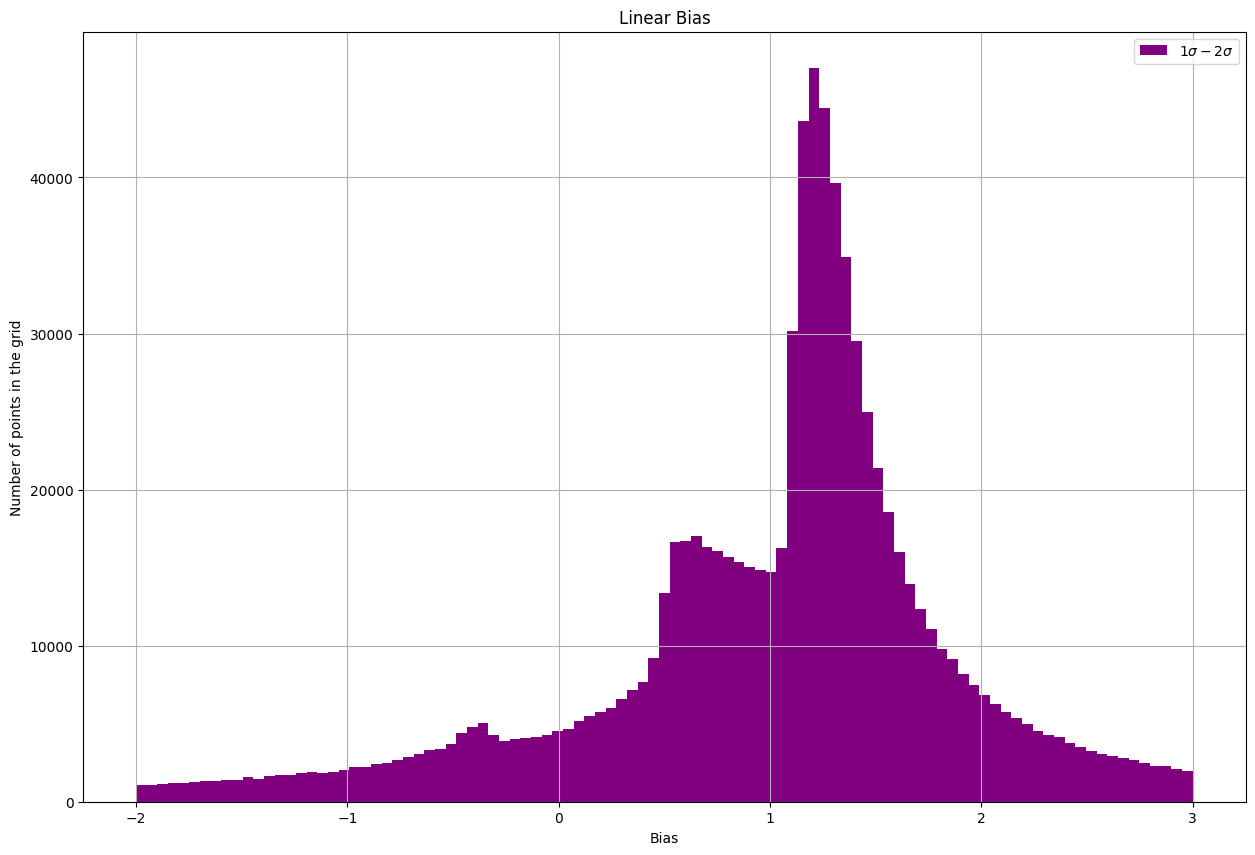

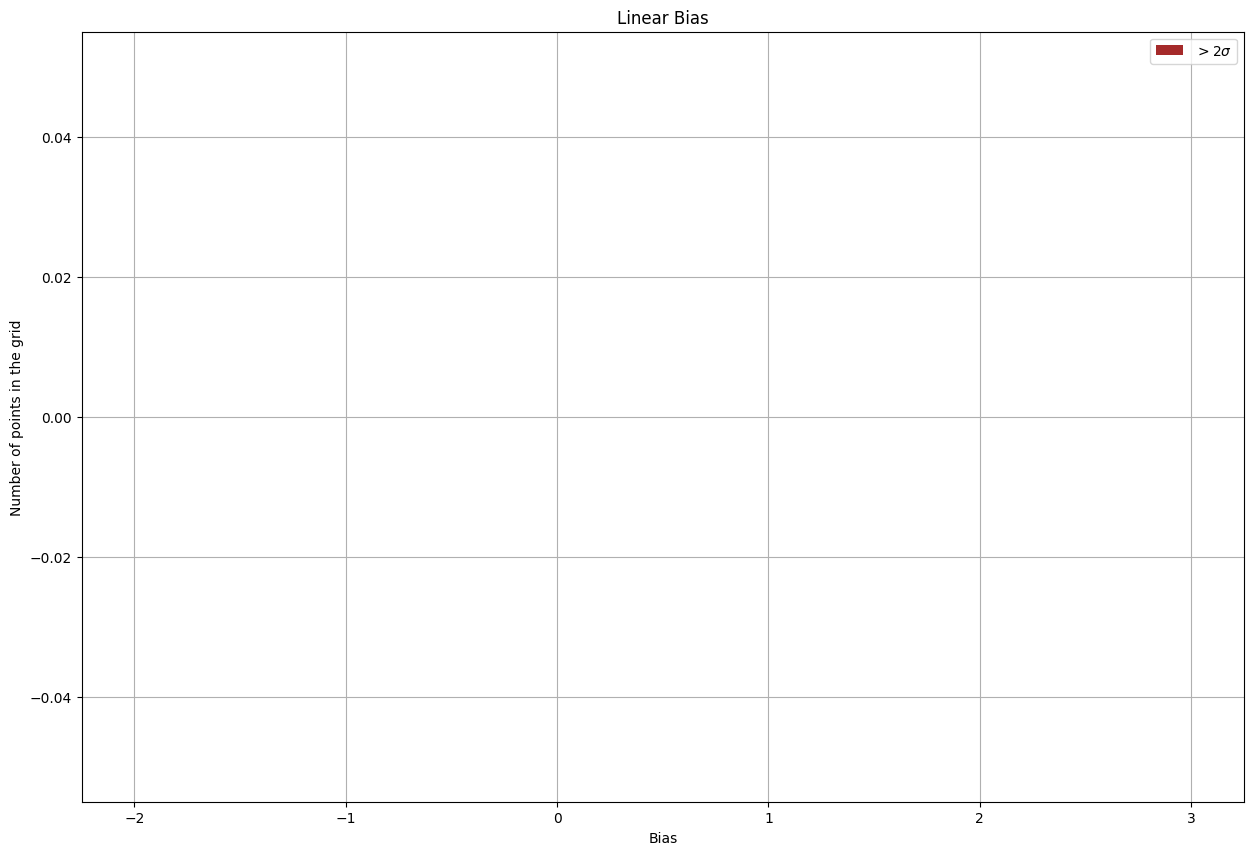

In [65]:
label_list=[r"$<-2\sigma$",r"$-2\sigma{} - -1\sigma$",r"$-1\sigma{} - \mu$",r"$\mu{} - 1\sigma$",r"$1\sigma{} - 2\sigma$",r"$>2\sigma$"]
b_list=[]
color_list=["blue", "orange", "green", "red", "purple", "brown"]
for i in range(len(smoothed_list)):
    b=(smoothed_list[i]/delta_smoothed).flatten()
    label_list.append(lab)
    b_list.append(b)



plt.figure(figsize=(15,10))
hist = plt.hist(b_list, bins = np.linspace(-2,3,1000),label=label_list,stacked=True,density=False, color=color_list)
plt.legend()
plt.title('Linear Bias')
plt.xlabel('Bias')
plt.ylabel('Number of points in the grid')
plt.grid()
plt.savefig("Bias_Stack.png",format="png")
plt.show()

for i in range(len(b_list)):
    plt.figure(figsize=(15,10))
    hist = plt.hist(b_list[i], bins = np.linspace(-2,3,100),label=label_list[i],color=color_list[i])
    plt.legend()
    plt.title('Linear Bias')
    plt.xlabel('Bias')
    plt.ylabel('Number of points in the grid')
    plt.savefig("Bias_Stack"+str(i)+".png",format="png")
    plt.grid()
    plt.show()

In [66]:
for i in lum_list:
    tempk_mag=i['K_Mag']

    tempk_mean=tempk_mag.mean()
    print(len(i))
    print(tempk_mean)

1337
-25.133962860292204
7264
-23.944330826033866
12972
-22.666424154766997
16111
-21.35133669358546
9059
-20.344231666950936
0
nan
